In [ ]:
# cell for importing packages for the first time
# import Pkg; Pkg.add("StaticArrays")
# import Pkg; Pkg.add("Revise")


import Pkg; Pkg.add("@time")

In [6]:
ENV["PYTHON"]=""
import Pkg;
Pkg.add("PyCall")

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %Fetching: [======>                                  ]  13.5 %                         ]  35.9 % [====================>                    ]  48.1 %7 %>            ]  67.9 %Fetching: [==============================>          ]  73.9 %Fetching: [================================>        ]  78.5 %   ]  90.6 %Fetching: [=======================================> ]  96.4 %Fetching: [=======================================> ]  96.7 %Fetching: [=======================================> ]  96.9 %Fetching: [=======================================> ]  97.4 %

  Resolving package versions...
  Installed Zlib_jll ──── v1.2.11+14
  Installed OpenSSL_jll ─ v1.1.1+4
  Installed PyCall ────── v1.91.4
######################################################################### 100.0%#=#=#                                                                          
   Updating `~/.julia/environments/v1.4/Project.toml`
  [438e738f] + PyCall v1.91.4
   Updating `~/.julia/environments/v1.4/Manifest.toml`
  [458c3c95] ↑ OpenSSL_jll v1.1.1+3 ⇒ v1.1.1+4
  [438e738f] + PyCall v1.91.4
  [83775a58] ↑ Zlib_jll v1.2.11+12 ⇒ v1.2.11+14
   Building PyCall → `~/.julia/packages/PyCall/zqDXB/deps/build.log`


In [9]:
Pkg.add("PyPlot")

  Resolving package versions...
  Installed PyPlot ─ v2.9.0
   Updating `~/.julia/environments/v1.4/Project.toml`
  [d330b81b] + PyPlot v2.9.0
   Updating `~/.julia/environments/v1.4/Manifest.toml`
  [d330b81b] + PyPlot v2.9.0


In [1]:
using Plots

using StaticArrays
import LinearAlgebra

push!(LOAD_PATH, pwd())

module PhysConst
    export CL,Gr,QE,MSOL,MSUN,ARAD,SGMB,RGAS,
            PC,RSUN,RSUN,YR,MSOLYR,GAM53,KPE,PARSEC,KPE,KPD,M_MW
    CL = 2.997925E10;
    Gr = 6.67384E-8; 
    QE=4.80325E-10;
    MSOL = 1.989E33;
    MSUN = 1.989E33;

    ARAD = 7.56464E-15; 
    SGMB = ARAD*CL/4

    RGAS = 8.31E7; 
    PC = 3.085678E18;
    MP = 1.672661E-24; 
    M_U = 1.660531E-24
    RSOL = 6.95E10
    RSUN = 6.95E10
    YR = 365*24*3600.
    MSOLYR = 1.989e33/YR

    GAM = 5/3.

    KPE = 0.4
    PARSEC=3.0E18
    KPD = 10.

    M_MW=1.

    tst=1

end



Main.PhysConst

In [10]:
using PyPlot
# use x = linspace(0,2*pi,1000) in Julia 0.6
x = range(0; stop=2*pi, length=1000); y = sin.(3 * x + 4 * cos.(2 * x));
plot(x, y, color="red", linewidth=2.0, linestyle="--")
title("A sinusoidally modulated sinusoid")

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260
┌ Info: Installing matplotlib via the Conda matplotlib package...
└ @ PyCall /Users/avdorodn/.julia/packages/PyCall/zqDXB/src/PyCall.jl:697
┌ Info: Running `conda install -y matplotlib` in root environment
└ @ Conda /Users/avdorodn/.julia/packages/Conda/3rPhK/src/Conda.jl:113


Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/avdorodn/.julia/conda/3

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cycler-0.10.0              |           py37_0          14 KB
    freetype-2.10.2            |       ha233b18_0         570 KB
    kiwisolver-1.2.0           |   py37h04f5b5a_0          55 KB
    libpng-1.6.37              |       ha441bb4_0         262 KB
    matplotlib-3.2.2           |                0          21 KB
    matplotlib-base-3.2.2      |   py37h5670ca0_0         5.4 MB
    pyparsing-2.4.7            |             py_0          65 KB
    ------------------------------------------------------------
                                           Total:         6.3 MB

The following NEW packages will be INSTALLED:

  cycler             pkgs/main/osx-64::cycler-0.10.0-py37_0
  

UndefVarError: UndefVarError: plot not defined

In [32]:

#-------------------------------------- STEP 1 -------------------------------------- #
# define necessary data structures

# module SpaceGrid


using StaticArrays
import Base.@kwdef

    const IX = 1
    const IY = 2
    const IZ = 3

    const BIGNUMBER = 10.0^50



    @kwdef struct SGridPar
        

        Nactive = 10;
    
        nghost = 1 #N of ghost cells at every boundary.
            
        Nx = Nactive;   # N of active cells
        Ny = Nactive;
        Nz = Nactive;
        
        Nxtot = Nx +  2*nghost;
        Nytot = Ny +  2*nghost;
        Nztot = Nz +  2*nghost;
    
        is = 1 + nghost; 
        ie = Nxtot -nghost;        

        js = 1 + nghost;  
        je = Nytot - nghost;
        
        ks = 1 + nghost;
        ke = Nztot - nghost;
            
        x1s = -1.
        x1e = 1.
    
        x2s = -1.
        x2e = 1.

        x3s = -1.
        x3e = 1.
        
    end

    @kwdef struct RGridPar
    
        Nfreq = 1 ; # ν - N bins 
        NumPhi = 5
        NumTheta = 5
    
        Nang = NumPhi*NumTheta
    
        N_fre_ang = Nfreq*Nang    
    
    end


# ------ define instances ----------

sg= SGridPar()

@show rad = RGridPar()

# ----------------------------------

x1 = Array{Float64}(undef, sg.Nxtot)
x2 = Array{Float64}(undef, sg.Nytot)
x3 = Array{Float64}(undef, sg.Nztot)

x1b = Array{Float64}(undef, sg.Nxtot)
x2b = Array{Float64}(undef, sg.Nytot)
x3b = Array{Float64}(undef, sg.Nztot)


@time ir = zeros(Float64, rad.N_fre_ang, sg.Nx, sg.Ny, sg.Nz); # radiation intensity



function MakeGrid(x1, x2, x3, x1b, x2b, x3b, sg)  #staggered grid

    # add check sizes
    
    xtmp = range(sg.x1s, sg.x1e; length = sg.Nxtot - 2sg.nghost)
    
#     @show sg.is, sg.ie sg.Nx sg.nghost size(xtmp) size(x1) size(sg.is:sg.ie) size(2:2)
    
    x1[sg.is:sg.ie] .= xtmp[:] 
    x1[sg.is-1] = 2*x1[sg.is]- x1[sg.is+1]
    x1[sg.ie+1] = 2*x1[sg.ie] -x1[sg.ie-1]

    xtmp = range(sg.x2s, sg.x2e; length = sg.Nytot - 2sg.nghost)    

    x2[sg.js:sg.je] .= xtmp[:]     
    x2[sg.js-1] = 2*x2[sg.js]- x2[sg.js+1]
    x2[sg.je+1] = 2*x2[sg.je] -x2[sg.je-1]

    xtmp = range(sg.x3s, sg.x3e; length = sg.Nztot - 2sg.nghost)    

    x3[sg.ks:sg.ke] .= xtmp[:]     
    x3[sg.ks-1] = 2*x3[sg.ks]- x3[sg.ks+1]
    x3[sg.ke+1] = 2*x3[sg.ke] -x3[sg.ke-1]
    
    
    x1b[1] = x1[1] - 0.5(x1[sg.is]-x1[1])    
    for i in sg.is:(sg.ie+1)
        x1b[i] = x1[i-1] + 0.5(x1[i]-x1[i-1])
    end

    x2b[1] = x2[1] - 0.5(x2[sg.js]-x2[1])    
    for j in sg.js:(sg.je+1)
        x2b[j] = x2[j-1] + 0.5(x2[j]-x2[j-1])
    end

    x3b[1] = x3[1] - 0.5(x3[sg.ks]-x3[1])    
    for k in sg.ks:(sg.ke+1)
        x3b[k] = x3[k-1] + 0.5(x3[k]-x3[k-1])
    end
    
    
    
end


MakeGrid(x1,x2,x3,x1b,x2b,x3b,sg)
@show x3
@show x3b

@kwdef mutable struct LongRay1
#     first time calculation of the long ray
    
    numOfElm::Int32
    
    dir = Vector{Float64}  #direction
    
    ijkOfCellCrossed:: Matrix{Int32}
        
    xyzPos ::Matrix{Float64}

end


#  allocate one big array
@time begin
    
    NumElemInRay = max(sg.Nxtot,sg.Nytot,sg.Nztot)


    rayOne = LongRay1(NumElemInRay, zeros(Float64,3), Array{Int32}(undef,3,NumElemInRay),  Array{Float64}(undef,3,NumElemInRay) )
    

    
    arrOfLongRay = Array{LongRay1, 4}(undef, (rad.N_fre_ang, sg.Nxtot, sg.Nytot, sg.Nztot));    

    for m = 1:rad.N_fre_ang, i=1:sg.Nxtot, j=1:sg.Nytot, k=1:sg.Nztot
        
        arrOfLongRay[m,i,j,k] = LongRay1(NumElemInRay, zeros(Float64,3), Array{Int32}(undef,3,NumElemInRay), Array{Float64}(undef,3,NumElemInRay) )

    end

    
end


# end



rad = RGridPar() = RGridPar(1, 5, 5, 25, 25)
  0.000027 seconds (4 allocations: 195.484 KiB)
x3 = [-1.2222222222222223, -1.0, -0.7777777777777778, -0.5555555555555556, -0.3333333333333333, -0.1111111111111111, 0.1111111111111111, 0.3333333333333333, 0.5555555555555556, 0.7777777777777778, 1.0, 1.2222222222222223]
x3b = [-1.3333333333333335, -1.1111111111111112, -0.8888888888888888, -0.6666666666666667, -0.4444444444444444, -0.2222222222222222, 0.0, 0.2222222222222222, 0.4444444444444444, 0.6666666666666667, 0.8888888888888888, 1.1111111111111112]
  0.037416 seconds (312.67 k allocations: 36.284 MiB)


In [95]:
# module RadiationTransfer

x3c = Array{Float64}(undef, 3);
xn = Array{Float64}(undef, 3)

function FirstTimeTraceGridOverOneLongRay(rayOne::LongRay1, sg::SGridPar)


#     @show rayOne.dir
    
    dist = 0.0   
    distToNextCell .= BIGNUMBER

    xn .= x3c

    itermax = 2 * sg.Nx

    for iter in 1:itermax #max length, may be smaller than actual

#     @show iter



        for (n_it, norm_i ) in enumerate(rayOne.dir) #QUESTION: maybe iter over pre-calclulated 1/norms


          xc = x3c[n_it] 

             if iter > 1 

                itmp = ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, rayOne.dir[n_it])

                @debug  " debug: (itmp, iter)= " , itmp, iter

                xn[n_it] = xbi_zip[n_it][itmp]                                            


             elseif iter==1 #first step from the middle of the cell

                if norm_i>0                
                   itmp = ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, rayOne.dir[n_it])                     
                elseif norm_i <0               
                    itmp = ijk_tmp[n_it] = ijk_pos[n_it]  #belongs to the same index                                
                else                
                    itmp = ijk_pos[n_it]            
                end

                xn[n_it] = xbi_zip[n_it][itmp]

             end


             if norm_i != 0                      
                distToNextCell[n_it] = abs((xn[n_it] - xc)/rayOne.dir[n_it])
             else
                distToNextCell[n_it]=BIGNUMBER
             end


        #println("iter= ",iter," xn=", xn, " ===> ", "distToNextCell[",n_it,"]=",distToNextCell[n_it])



        end #for loop over norm_i     

            posIndxToUpdate = argmin(distToNextCell)
            dist = distToNextCell[posIndxToUpdate]


        ijk_pos[posIndxToUpdate] = ijk_tmp[posIndxToUpdate] #update only relevant one
    

        #println("ijk_pos[posIndxToUpdate = ", posIndxToUpdate, "]",  "  =  ",   ijk_pos  )


        xn .= x3c + rayOne.dir*dist
        x3c .= xn

        #update rayOne
        rayOne.numOfElm = iter
        rayOne.ijkOfCellCrossed[:,iter] .= ijk_pos
        rayOne.xyzPos[:,iter] .= xn

#         println("xn=", xn)

        if ijk_pos[posIndxToUpdate] == ijk_max[posIndxToUpdate] || ijk_pos[posIndxToUpdate] == ijk_min[posIndxToUpdate] || ijk_pos[posIndxToUpdate] == 1 || iter > 100 
            break; 
        end      

    end #over ray

end # FirstTimeTraceGridCalcOneLongRay


function InitNorm(rad::RGridPar, sg::SGridPar)
    th = range(0, pi; length = rad.NumPhi)
    ph = range(0, 2pi-pi/rad.NumTheta; length = rad.NumTheta)
@show th, ph
    norm = zeros(Float64, rad.Nang, 3);
    

    m=1
    for (i,ph_i) in enumerate(ph)
        for (j,th_j) in enumerate(th)
                        
            norm[m, IX] =  sin(th_j)sin(ph_i)
            norm[m, IY] = sin(th_j)cos(ph_i)                 
            norm[m, IZ] = cos(th_j)
                        
        m+=1;            
        end
    end

    # LinearAlgebra.norm(norm[9,:])

    return(norm)
end



function InitArrOfLongRay(norm::Array{Float64,2}, rayArr::Array{LongRay1,4}, rad::RGridPar, sg::SGridPar)
 
    for m in 1:rad.N_fre_ang, ipos=1:sg.Nxtot, jpos=1:sg.Nytot, kpos=1:sg.Nztot
        rayArr[m, ipos,jpos,kpos].dir[:]  =  norm[m,:]
    end
           
end

norm = InitNorm(rad,sg)

InitArrOfLongRay(norm, arrOfLongRay, rad, sg);
   
# checkup
let 
    m = rand(1:rad.N_fre_ang)
    arrOfLongRay[m, rand(1:sg.Nx),rand(1:sg.Ny),rand(1:sg.Nz) ].dir - norm[m,:]    
end
   
function PlotRay(ray, sg)
    
    x = ray.xyzPos[1,1:ray.numOfElm]
    y = ray.xyzPos[2,1:ray.numOfElm]   
    z = ray.xyzPos[3,1:ray.numOfElm]      
    
    @show ray.numOfElm,x,y,z

    plot3d(x,y,z,
        xlabel = "x", ylabel = "y", zlabel = "z", 
        xlim= (sg.x1s,sg.x1e),ylim= (sg.x2s,sg.x2e),zlim= (sg.x3s,sg.x3e))    
end




distToNextCell = fill(BIGNUMBER,3) #used in FirstTimeTraceGridOverOneLongRay()

ijk_pos = Array{Int64}(undef,3)
ijk_max = [ sg.ie+1, sg.je+1, sg.ke+1 ] #max ijk index 
ijk_min = [ sg.is, sg.js, sg.ks ] #min index
ijk_tmp = [0, 0, 0]

xbi_zip = [x1b, x2b, x3b]

ijk_pos_s = [rand(sg.is:sg.ie),  rand(sg.js:sg.je),  rand(sg.ks:sg.ke) ]
ijk_pos_s = [argmin(abs.(x1.-0.)), argmin(abs.(x2.-0.)), argmin(abs.(x3.-0.))];

for m in 1:rad.N_fre_ang #, ipos=1:sg.Nxtot, jpos=1:sg.Nytot, kpos=1:sg.Nztot
    
    ijk_pos .= ijk_pos_s
    
    x3c .= [ x1[ijk_pos[IX]], x2[ijk_pos[IY]], x3[ijk_pos[IZ]] ]
#     @show m , x3c , ijk_pos

#     if m > 
#         break        
#     end
        
    rayOne = arrOfLongRay[m, ijk_pos[IX], ijk_pos[IY], ijk_pos[IZ]]
    
    
    FirstTimeTraceGridOverOneLongRay(rayOne, sg)    
    
 
    #     plt=PlotRay(rayOne, sg); display(plt)    
    
end





# display(plt)    
# inline()
# end #module RadiationTransfer





(th, ph) = (0.0:0.7853981633974483:3.141592653589793, 0.0:1.413716694115407:5.654866776461628)


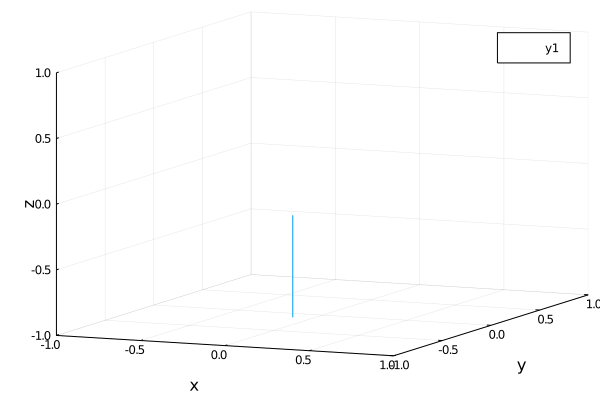

ijk_pos_s = [6, 6, 6]
ray.dir = [-7.19829327805997e-17, 9.907600726170915e-17, -1.0]


In [96]:
ray = arrOfLongRay[rand(1:rad.Nang), ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]
    
@show ijk_pos_s ray.dir

plt=plot3d(ray.xyzPos[1,1:ray.numOfElm],
        ray.xyzPos[2,1:ray.numOfElm],
        ray.xyzPos[3,1:ray.numOfElm],
        xlabel = "x", ylabel = "y", zlabel = "z", 
        xlim= (sg.x1s,sg.x1e),ylim= (sg.x2s,sg.x2e),zlim= (sg.x3s,sg.x3e))

 
display(plt)


In [94]:
# function xyzToijk(xin::Float64, yin::Float64, zin::Float64, x1::Array{Float64,1}, x2::Array{Float64,1},x3::Array{Float64,1})
#     i = argmin( abs.(x1 .-xin )); 
#     j = argmin(abs.(x2.-yin)); 
#     k = argmin(abs.(x3.-zin))    
#     return(i,j,k)
# end

# typeof(x1)

    
i = argmin(abs.(x1.-0.)); 


# GetIndxGiveCoords1(0., 0., 0., x1, x2, x3)




In [68]:
function FotrieAlongTheRay()
    
    
    
    
    
end

6

In [3]:

# module RadTransfer
    

ijk_pos = Array{Int64}(undef,3)
ijk_max = [ sg.ie+1, sg.je+1, sg.ke+1 ] #max ijk index 
ijk_min = [ sg.is, sg.js, sg.ks ] #min index

distToNextCell = fill(BIGNUMBER,3) #used in FirstTimeTraceGridOverOneLongRay()




norm[1, IX, :, :, :] .=  1
norm[1, IY, :, :, :] .= -1
norm[1, IZ, :, :, :] .= -1



iOf_0 = argmin(abs.(x1)); jOf_0 = argmin(abs.(x2)); kOf_0 = argmin(abs.(x3))
# ijk_pos .= [sg.is, sg.js, sg.ks]
# ijk_pos .= [iOf_0, div(sg.je,2), div(sg.ke,2)]
# ijk_pos .= [sg.ie, sg.je, sg.ke]

ijk_pos .= [iOf_0,  jOf_0,  kOf_0]
ijk_tmp = [0, 0, 0]



rayOne.dir .= [norm[1, IX, 1, 1, 1], norm[1, IY, 1, 1, 1] , norm[1, IZ, 1, 1, 1]]


rayOne.dir=LinearAlgebra.normalize(rayOne.dir)

@show rayOne.dir

# rayOne.rayOne.dir = norm3 #update ray direction
# norm3 = [norm[1, IX, 1, 1, 1], norm[1, IY, 1, 1, 1] , norm[1, IZ, 1, 1, 1]]
# should replace 1/norm just in case when Float norm==0.
#          one2norm_i = max(abs())

xbi_zip = [x1b, x2b, x3b]



@show ijk_pos

x3c = [ x1[ijk_pos[IX]], x2[ijk_pos[IY]], x3[ijk_pos[IZ]] ]

# @show x3c
# @show x1
# @show x1b

# @show x2
# @show x2b

# @show x3
# @show x3b

# @show xbi_zip[2]


FirstTimeTraceGridOverOneLongRay(rayOne, sg)







# end #module RadTransfer

rayOne = LongRay1(10, [0.0, 0.0, 0.0], Int32[799685648 1 799685792 1 799685936 1 799686080 1 799686224 1 799686368 1; 1 799685744 1 799685888 1 799686032 1 799686176 1 799686320 1 799686464; 799685696 1 799685840 1 799685984 1 799686128 1 799686272 1 799686416 1], [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0])
rayOne.dir = [0.5773502691896258, -0.5773502691896258, -0.5773502691896258]
ijk_pos = [6, 6, 6]
xn=[0.0, -0.2222222222222222, -0.2222222222222222]
xn=[0.2222222222222222, -0.4444444444444444, -0.4444444444444444]
xn=[0.2222222222222222, -0.4444444444444444, -0.4444444444444444]
xn=[0.2222222222222222, -0.4444444444444444, -0.4444444444444444]
xn=[0.4444444444444444, -0.6666666666666666, -0.6666666666666666]
xn=[0.44444444444444453, -0.6666666666666667, -0.6666666666666667]
xn=[0.44444444444444453, -0.6666666666666667, -0.6666666666666667]
xn=[0.6666666666666666, -0.88888888888888

In [ ]:
#-------------------------------------- STEP 2 -------------------------------------- #



# @show size(norm);



In [7]:
# logger=Logging.SimpleLogger(stderr,Logging.Debug)

function TestOneRay(ray, sg)
    xyz_s=Vector{Float64}(undef,3)    
    xyz_e=Vector{Float64}(undef,3)    
    xyz_0e=Vector{Float64}(undef,3)
    
    xyz_s .= ray.xyzPos[:,1]
    
    xyz_e = ray.xyzPos[:,ray.numOfElm]

     dist =LinearAlgebra.norm( xyz_e[:].-xyz_s[:]) 
    
    xyz_0e = xyz_s + ray.dir*dist
    
    
    @show xyz_e, xyz_0e, dist
    
    println("|| rend - rs || = ",  LinearAlgebra.norm( xyz_e[:].-xyz_0e[:]) )
    
end


TestOneRay(rayOne, sg)



(xyz_e, xyz_0e, dist) = ([0.8888888888888888, -1.1111111111111112, -1.1111111111111112], [0.8888888888888891, -1.1111111111111112, -1.1111111111111112], 1.539600717839002)
|| rend - rs || = 2.220446049250313e-16


In [ ]:
module debugByPlot

using Plots
# x= LinRange(0,30,10)

# import 

x = [0.5, 1.]
y = [0., 1.]
z = [0., 0.1];


plt=plot3d(x,y,z)



end


In [ ]:
# function mtest()
# L = M = N = Int(5e2);

# vec_vec_vec = Array{Array{Vector}}(L);

# for i = 1:L vec_vec_vec[i] = [zeros(N) for j = 1:M] end;

# vec_mat = Array{Matrix}(L);

# fill!(vec_mat, rand(M, N));

# arr = rand(L, M, N);

# @time  for i = 1:L for j = 1:M for k = 1:N vec_vec_vec[i][j][k] += 1; end; end; end; 

# @time  for i = 1:L for j = 1:M for k = 1:N vec_mat[i][j,k] += 1; end; end; end; 

# @time  for k = 1:N for j = 1:M for i = 1:L arr[i,j,k] += 1; end; end; end; 

# end
# mtest()



# mutable struct SegmentData{
#  /*! cell data along the trajectory */
#   /*!  current index of cell along the ray, phi index is the same */
#   /*! if the source is symmetrical */
#   int i,k;    
#   float dl; //length element    
# }SegmentData;

# RayCellInd1 = Array{Int32}(undef,1)
# RayCellInd2 = Array{Int32}(undef,1)
# RayCellInd3 = Array{Int32}(undef,1)
# push!(RayCellInd1, 1)
# RayCellInd1 .=0
# RayCellInd2 .=0
# RayCellInd3 .=0


# create array of ray directions, mu, for every ijk cell (nx,ny,nz) components
# for every ray; 
# nang - number of rays per cell 



# RayData = Array of ( (iCross, jCross, kCross), NcrossCells,(istart, jstart, kstart)=3)
# NcrossCells=3
# @time RayData = zeros(3,  zeros(3),  3)





In [ ]:
copysign(1, 0)

In [ ]:
import Pkg; Pkg.add("Plotly")

In [ ]:
# using Plotly
# default(show = true)
# plotly()
